In [1]:
import pandas as pd
import numpy as np
import duckdb
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
cmap = sns.color_palette("flare", as_cmap=True)
import matplotlib.ticker as mtick
plt.style.use('ggplot')

from shapley_decomposition import shapley_r2

In [3]:
regular_season_stats = pd.read_sql("""WITH game_log AS (
	SELECT *
	,ROW_NUMBER() OVER(PARTITION BY team_id, season_id ORDER BY game_date) game_num
	FROM vw_league_game_log
	WHERE season >= 2013
		AND season NOT IN (2020, 2021)
		AND season_type = 'Regular Season')

	,game_log_w_halves AS (
	SELECT *
		,CASE WHEN game_num <= 41 THEN 1 ELSE 2 END half_of_season
	FROM game_log)

	,team_seasons_by_half AS (
	SELECT team_id
		,team_abbr
		,season
		--First Half
		,SUM(CASE WHEN half_of_season = 1 THEN three_pointers_made END) first_half_three_pts_made
		,SUM(CASE WHEN half_of_season = 1 THEN field_goals_made END) first_half_field_goals_made
		,SUM(CASE WHEN half_of_season = 1 THEN field_goals_att END) first_half_field_goals_att
		,SUM(CASE WHEN half_of_season = 1 THEN free_throws_made END) first_half_free_throws_made
		,SUM(CASE WHEN half_of_season = 1 THEN free_throws_att END) first_half_free_throws_att
		,SUM(CASE WHEN half_of_season = 1 THEN off_rebounds END) first_half_off_rebounds
		,SUM(CASE WHEN half_of_season = 1 THEN def_rebounds END) first_half_def_rebounds
		,SUM(CASE WHEN half_of_season = 1 THEN turnovers END) first_half_turnovers
		,SUM(CASE WHEN half_of_season = 1 THEN num_off_possessions END) first_half_num_off_possessions

		,SUM(CASE WHEN half_of_season = 1 THEN opp_three_pointers_made END) first_half_opp_three_pts_made
		,SUM(CASE WHEN half_of_season = 1 THEN opp_field_goals_made END) first_half_opp_field_goals_made
		,SUM(CASE WHEN half_of_season = 1 THEN opp_field_goals_att END) first_half_opp_field_goals_att
		,SUM(CASE WHEN half_of_season = 1 THEN opp_free_throws_made END) first_half_opp_free_throws_made
		,SUM(CASE WHEN half_of_season = 1 THEN opp_free_throws_att END) first_half_opp_free_throws_att
		,SUM(CASE WHEN half_of_season = 1 THEN opp_off_rebounds END) first_half_opp_off_rebounds
		,SUM(CASE WHEN half_of_season = 1 THEN opp_def_rebounds END) first_half_opp_def_rebounds
		,SUM(CASE WHEN half_of_season = 1 THEN opp_turnovers END) first_half_opp_turnovers
		,SUM(CASE WHEN half_of_season = 1 THEN num_def_possessions END) first_half_num_def_possessions

		--Second Half
		,SUM(CASE WHEN half_of_season = 2 THEN three_pointers_made END) second_half_three_pts_made
		,SUM(CASE WHEN half_of_season = 2 THEN field_goals_made END) second_half_field_goals_made
		,SUM(CASE WHEN half_of_season = 2 THEN field_goals_att END) second_half_field_goals_att
		,SUM(CASE WHEN half_of_season = 2 THEN free_throws_made END) second_half_free_throws_made
		,SUM(CASE WHEN half_of_season = 2 THEN free_throws_att END) second_half_free_throws_att
		,SUM(CASE WHEN half_of_season = 2 THEN off_rebounds END) second_half_off_rebounds
		,SUM(CASE WHEN half_of_season = 2 THEN def_rebounds END) second_half_def_rebounds
		,SUM(CASE WHEN half_of_season = 2 THEN turnovers END) second_half_turnovers
		,SUM(CASE WHEN half_of_season = 2 THEN num_off_possessions END) second_half_num_off_possessions

		,SUM(CASE WHEN half_of_season = 2 THEN opp_three_pointers_made END) second_half_opp_three_pts_made
		,SUM(CASE WHEN half_of_season = 2 THEN opp_field_goals_made END) second_half_opp_field_goals_made
		,SUM(CASE WHEN half_of_season = 2 THEN opp_field_goals_att END) second_half_opp_field_goals_att
		,SUM(CASE WHEN half_of_season = 2 THEN opp_free_throws_made END) second_half_opp_free_throws_made
		,SUM(CASE WHEN half_of_season = 2 THEN opp_free_throws_att END) second_half_opp_free_throws_att
		,SUM(CASE WHEN half_of_season = 2 THEN opp_off_rebounds END) second_half_opp_off_rebounds
		,SUM(CASE WHEN half_of_season = 2 THEN opp_def_rebounds END) second_half_opp_def_rebounds
		,SUM(CASE WHEN half_of_season = 2 THEN opp_turnovers END) second_half_opp_turnovers
		,SUM(CASE WHEN half_of_season = 2 THEN num_def_possessions END) second_half_num_def_possessions

		--Full Season
		,SUM(three_pointers_made) three_pts_made
		,SUM(field_goals_made) field_goals_made
		,SUM(field_goals_att) field_goals_att
		,SUM(free_throws_made) free_throws_made
		,SUM(free_throws_att) free_throws_att
		,SUM(off_rebounds) off_rebounds
		,SUM(def_rebounds) def_rebounds
		,SUM(turnovers) turnovers
		,SUM(num_off_possessions) num_off_possessions

		,SUM(opp_three_pointers_made) opp_three_pts_made
		,SUM(opp_field_goals_made) opp_field_goals_made
		,SUM(opp_field_goals_att) opp_field_goals_att
		,SUM(opp_free_throws_made) opp_free_throws_made
		,SUM(opp_free_throws_att) opp_free_throws_att
		,SUM(opp_off_rebounds) opp_off_rebounds
		,SUM(opp_def_rebounds) opp_def_rebounds
		,SUM(opp_turnovers) opp_turnovers
		,SUM(num_def_possessions) num_def_possessions
	FROM game_log_w_halves
	GROUP BY team_id, team_abbr, season
	)
SELECT team_id
	,team_abbr
	,season
	--First Half
	--Offense
	,(first_half_three_pts_made * 1.5 + (first_half_field_goals_made - first_half_three_pts_made))
		/ first_half_field_goals_att AS first_half_effective_field_goal_percentage
	,first_half_free_throws_made 
		/ first_half_field_goals_att AS first_half_free_throw_rate
	,first_half_off_rebounds 
		/ (first_half_off_rebounds + first_half_opp_def_rebounds) AS first_half_off_rebound_rate
	,first_half_turnovers 
		/ first_half_num_off_possessions AS first_half_turnover_rate
	--Defense
	,(first_half_opp_three_pts_made * 1.5 + (first_half_opp_field_goals_made - first_half_opp_three_pts_made))
		/ first_half_opp_field_goals_att AS first_half_opp_effective_field_goal_percentage
	,first_half_opp_free_throws_made 
		/ first_half_opp_field_goals_att AS first_half_opp_free_throw_rate
	,first_half_def_rebounds 
		/ (first_half_opp_off_rebounds + first_half_def_rebounds) AS first_half_def_rebound_rate
	,first_half_opp_turnovers 
		/ first_half_num_def_possessions AS first_half_opp_turnover_rate

	--Second Half
	--Offense
	,(second_half_three_pts_made * 1.5 + (second_half_field_goals_made - second_half_three_pts_made))
		/ second_half_field_goals_att AS second_half_effective_field_goal_percentage
	,second_half_free_throws_made 
		/ second_half_field_goals_att AS second_half_free_throw_rate
	,second_half_off_rebounds 
		/ (second_half_off_rebounds + second_half_opp_def_rebounds) AS second_half_off_rebound_rate
	,second_half_turnovers 
		/ second_half_num_off_possessions AS second_half_turnover_rate
	--Defense
	,(second_half_opp_three_pts_made * 1.5 + (second_half_opp_field_goals_made - second_half_opp_three_pts_made))
		/ second_half_opp_field_goals_att AS second_half_opp_effective_field_goal_percentage
	,second_half_opp_free_throws_made 
		/ second_half_opp_field_goals_att AS second_half_opp_free_throw_rate
	,second_half_def_rebounds 
		/ (second_half_opp_off_rebounds + second_half_def_rebounds) AS second_half_def_rebound_rate
	,second_half_opp_turnovers 
		/ second_half_num_def_possessions AS second_half_opp_turnover_rate	

	--Full Season
	--Offense
	,(three_pts_made * 1.5 + (field_goals_made - three_pts_made))
		/ field_goals_att AS effective_field_goal_percentage
	,free_throws_made 
		/ field_goals_att AS free_throw_rate
	,off_rebounds 
		/ (off_rebounds + opp_def_rebounds) AS off_rebound_rate
	,turnovers 
		/ num_off_possessions AS turnover_rate
	--Defense
	,(opp_three_pts_made * 1.5 + (opp_field_goals_made - opp_three_pts_made))
		/ opp_field_goals_att AS opp_effective_field_goal_percentage
	,opp_free_throws_made 
		/ opp_field_goals_att AS opp_free_throw_rate
	,def_rebounds 
		/ (opp_off_rebounds + def_rebounds) AS def_rebound_rate
	,opp_turnovers 
		/ num_def_possessions AS opp_turnover_rate	
FROM team_seasons_by_half


""", engine)

One way to measure a basketball team's performance is by breaking it down into a few key metrics called The Four Factors. The factors are:
* Effective Field Goal Percentage: Mesures shooting ability while adjusting for 3-pointers
* Offensive Rebounding Rate: The percentage of offensive rebounding opportunities that you convert
* Turnover Rate: The percentage of possessions that end in a turnover
* Free Throw Rate: (Free Throws Made) / (Field Goals Attempted). A measure of how often teams get to the line and make their free throws

While using metrics to evaluate how a team is performing, it's important to keep in mind how likely it is for that metric to be representative that the team's skill, rather than random variation or "luck". We know that random variation plays a crucial part in a team's success. Even Steph Curry has bad shooting nights that aren't predictable. But how can we measure that?

Well one simple method that is commonly used in sports analytics is to take two separate time periods, measure the statistic in question for both periods, and find the correlation between the two. So that's what I did here.

I took NBA regular season data going back to the 2012-13 season. I excluded 2020 and 2021 since fewer games were played in those years. For each year, I separated the data by half of the year - each team's first 41 games are in one half, and the last 41 are in the other half. Then we can look to see how strongly correlated the two halves are.

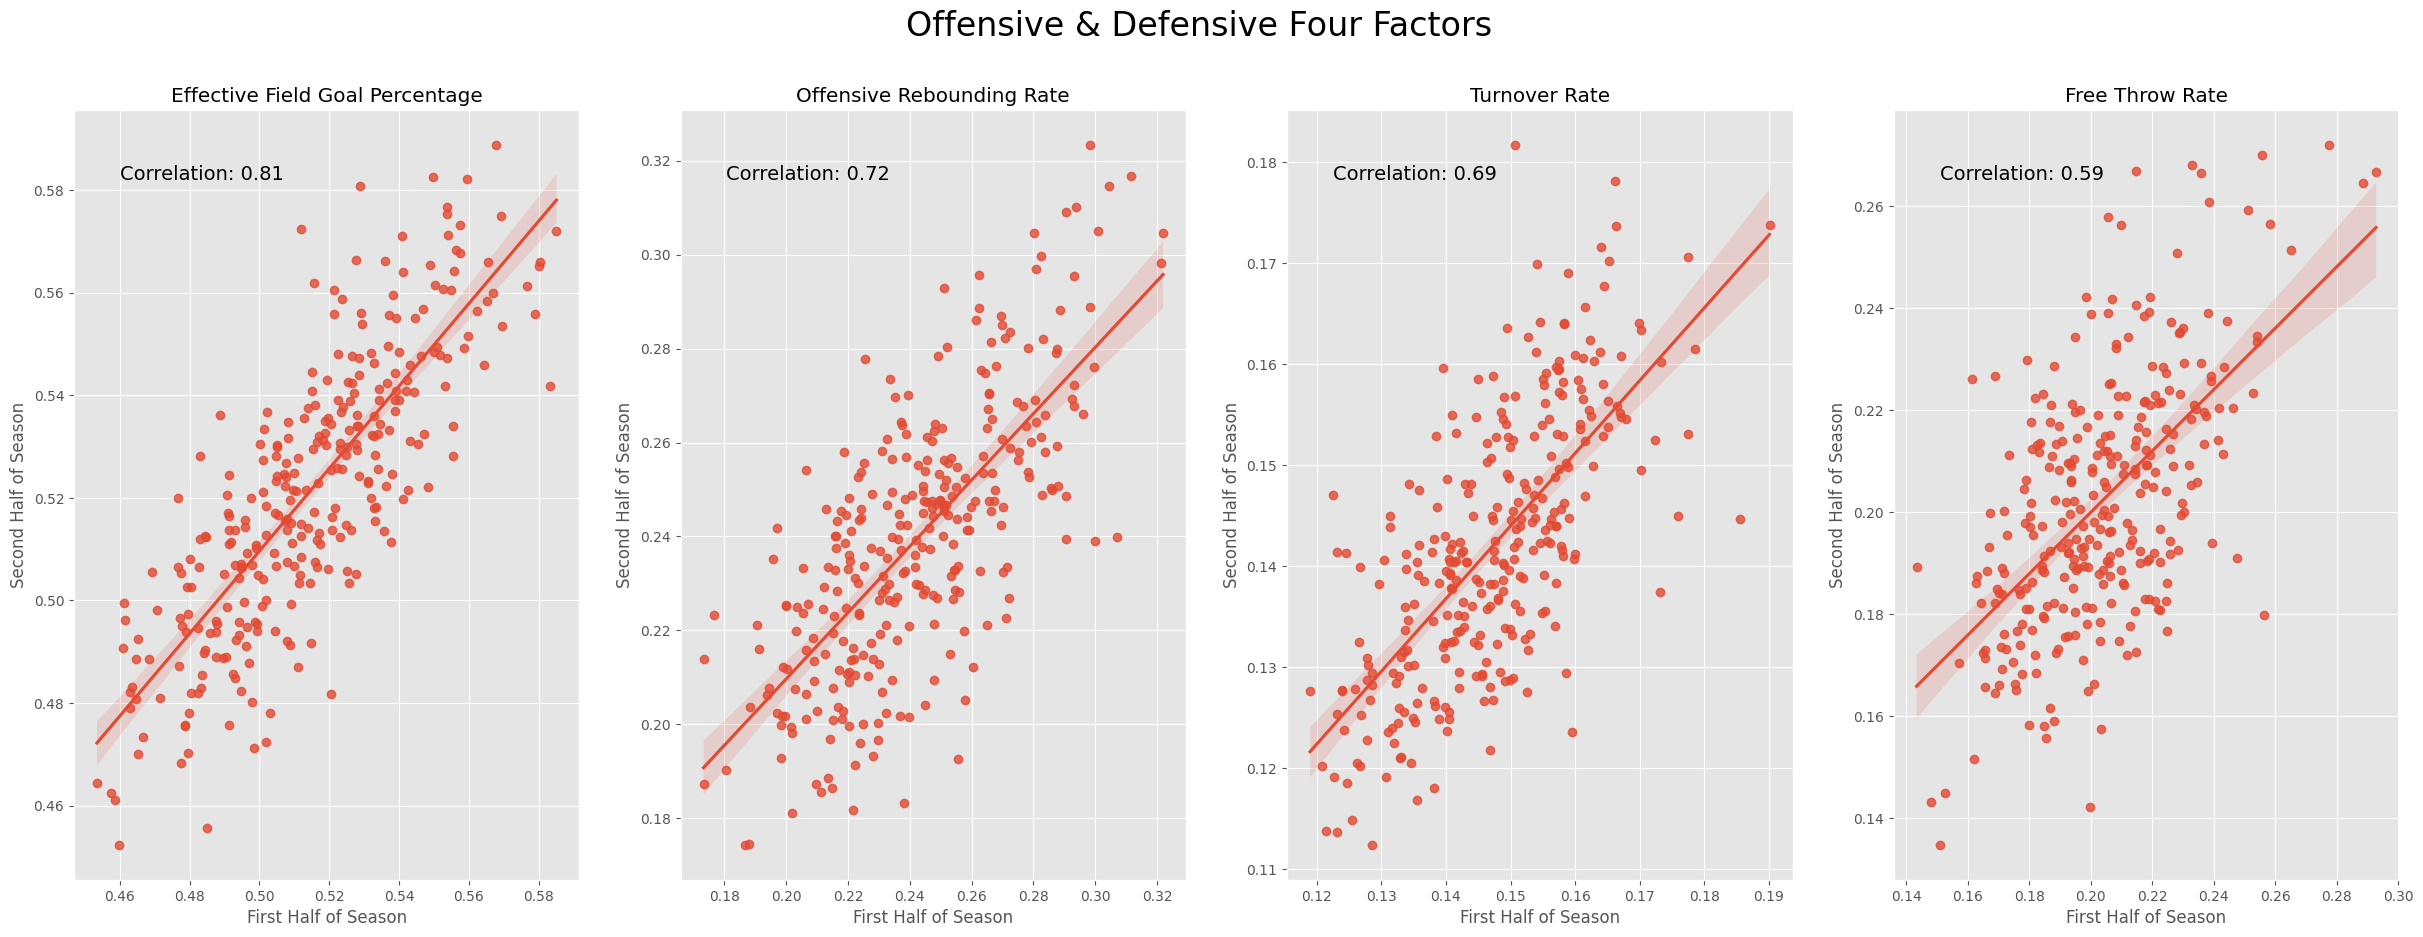

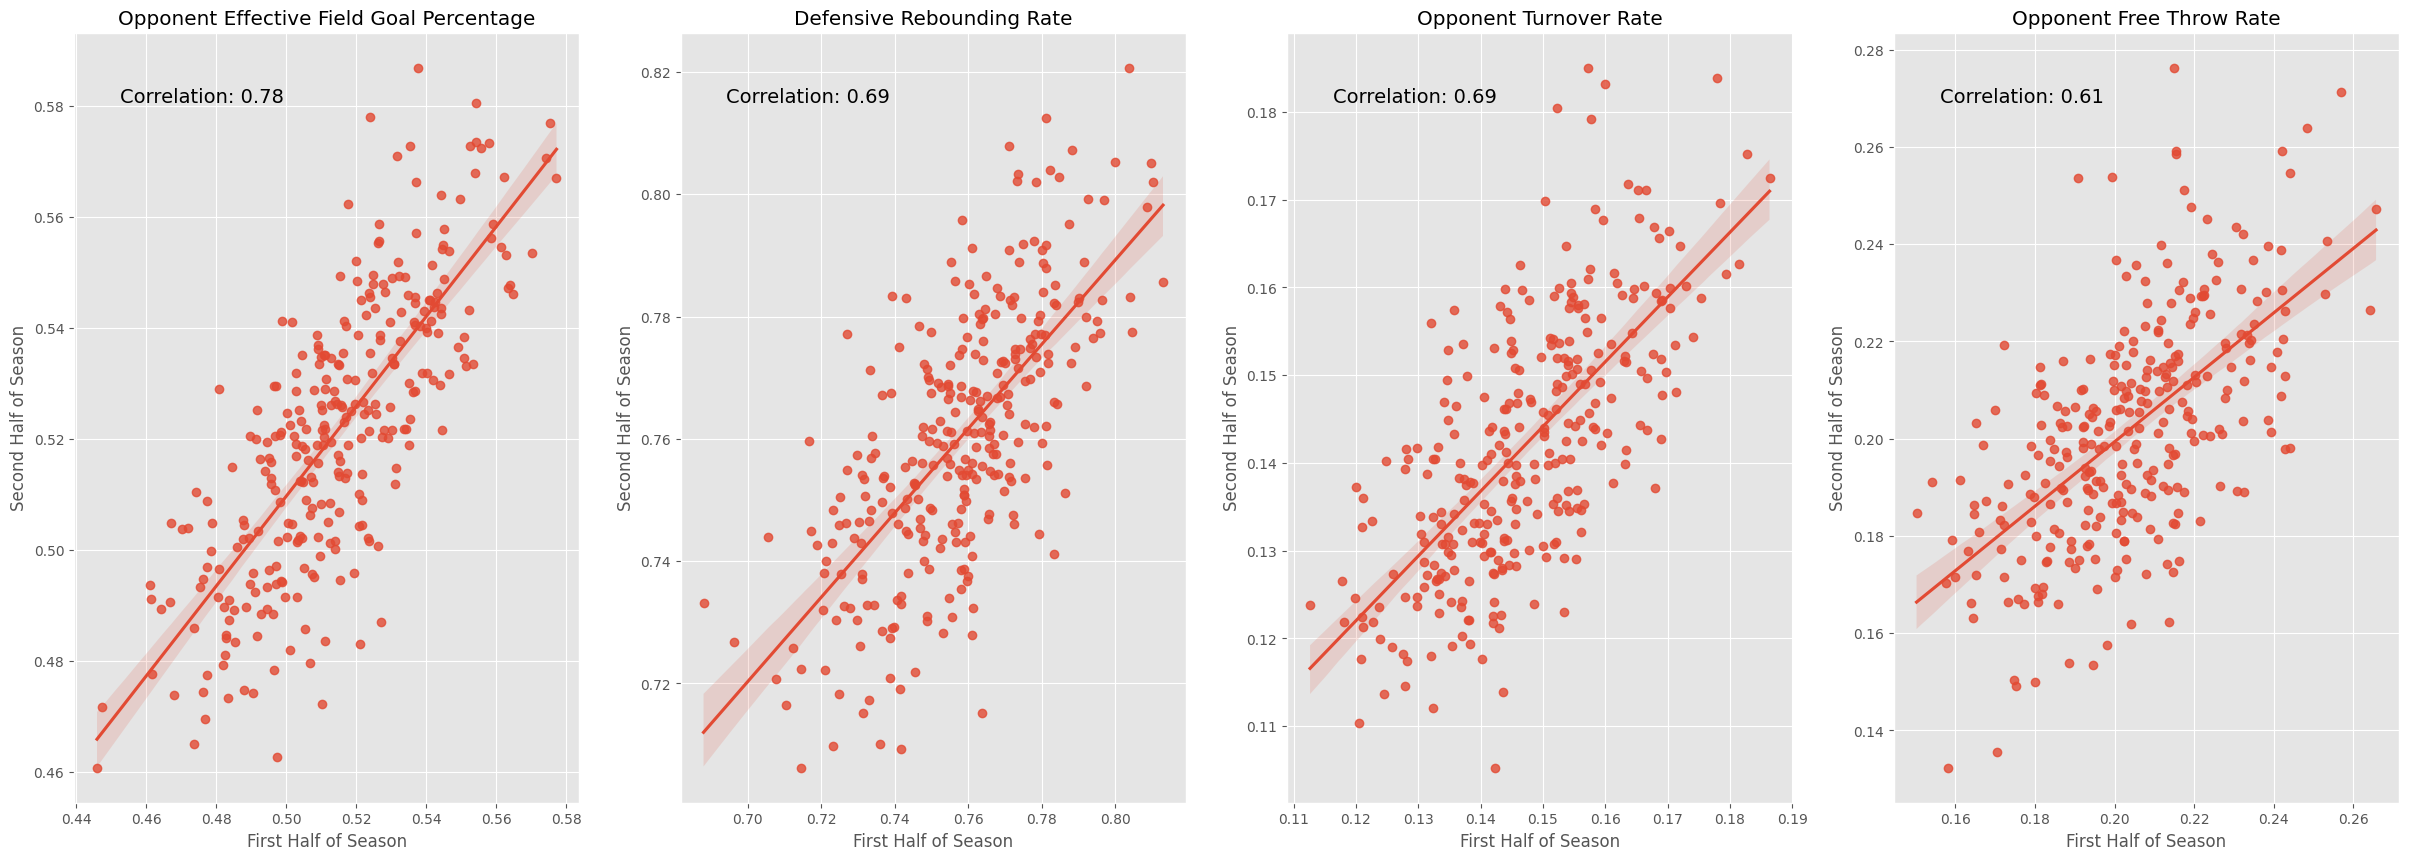

In [86]:
correlations = {}
off_four_factors = {'effective_field_goal_percentage': 'Effective Field Goal Percentage',
                    'off_rebound_rate': 'Offensive Rebounding Rate',
                    'turnover_rate': 'Turnover Rate',
                    'free_throw_rate': 'Free Throw Rate',
                    }

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
for i, factor in enumerate(off_four_factors.keys()):
    x = f'first_half_{factor}'
    y = f'second_half_{factor}'
    
    correlation = regular_season_stats[x].corr(regular_season_stats[y])
    correlations[off_four_factors[factor]] = {'Correlation': correlation,
                            'Side of Ball': 'Offense'}
    ax = axs[i]
    
    sns.regplot(data=regular_season_stats, x=x, y=y, ax=ax)
    ax.set_title(off_four_factors[factor])
    ax.set_xlabel('First Half of Season')
    ax.set_ylabel('Second Half of Season')
    
    x_loc = regular_season_stats[x].min() + 0.05 * (regular_season_stats[x].max() - regular_season_stats[x].min())
    y_loc = regular_season_stats[y].max() - 0.05 * (regular_season_stats[y].max() - regular_season_stats[y].min())
    
    ax.annotate(f'Correlation: {round(correlation, 2)}', xy=(x_loc, y_loc), xytext=(x_loc, y_loc), fontsize=14)
plt.suptitle("Offensive & Defensive Four Factors", fontsize=24)
plt.show()

def_four_factors = {'opp_effective_field_goal_percentage': 'Opponent Effective Field Goal Percentage',
                    'def_rebound_rate': 'Defensive Rebounding Rate',
                    'opp_turnover_rate': 'Opponent Turnover Rate',
                    'opp_free_throw_rate': 'Opponent Free Throw Rate',
                    }

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
for i, factor in enumerate(def_four_factors.keys()):
    x = f'first_half_{factor}'
    y = f'second_half_{factor}'
    
    
    correlation = regular_season_stats[x].corr(regular_season_stats[y])
    correlations[def_four_factors[factor]] = {'Correlation': correlation,
                            'Side of Ball': 'Defense'}
    ax = axs[i]
    
    sns.regplot(data=regular_season_stats, x=x, y=y, ax=ax)
    ax.set_title(def_four_factors[factor])
    ax.set_xlabel('First Half of Season')
    ax.set_ylabel('Second Half of Season')
    
    x_loc = regular_season_stats[x].min() + 0.05 * (regular_season_stats[x].max() - regular_season_stats[x].min())
    y_loc = regular_season_stats[y].max() - 0.05 * (regular_season_stats[y].max() - regular_season_stats[y].min())
    
    ax.annotate(f'Correlation: {round(correlation, 2)}', xy=(x_loc, y_loc), xytext=(x_loc, y_loc), fontsize=14)
plt.show()


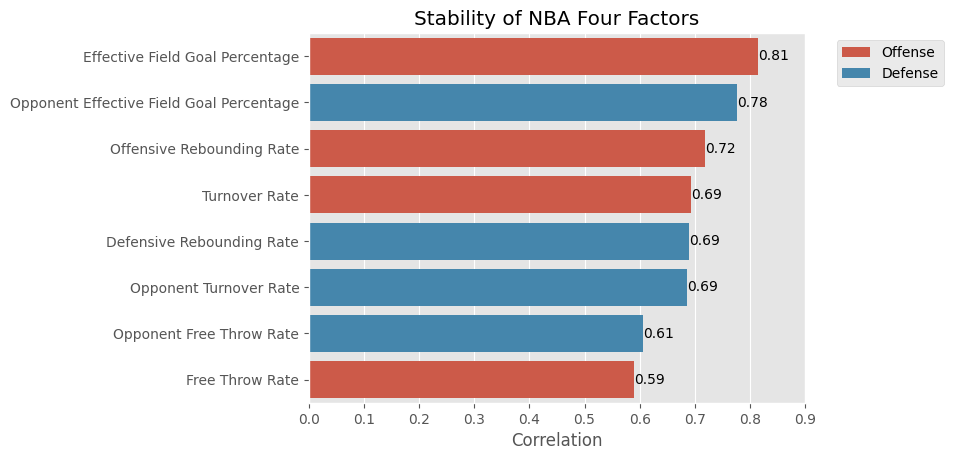

In [84]:
ax = sns.barplot(correlations_df, y="index", x="Correlation",
                 hue='Side of Ball',
                orient='h')

ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}')
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:.2f}')
ax.legend(bbox_to_anchor=(1.05, 1.))
ax.set_xlim(0, .9)
ax.set_ylabel("")
ax.set_title("Stability of NBA Four Factors");

The correlations tell us that Effective Field Goal % is the most stable of the four factors, both offensively and defensively. Over a period of time, this is the metric that depends most on the underlying skill of the team, rather than random variations.

Another interesting observation is that the offensive factors seem to be slightly more stable than the defensive ones. The differences aren't enormous, but that trend does seem to exist here. This tracks with the conventional wisdom that offenses have more control over their own play than the defense. The only one of the four factors this isn't true for is free throw rate. The ability to not foul the other team is more stable than the ability to draw fouls.

### Translating to The Playoffs

Since most NBA fans recongnize that playoff basketball is so different from the regular season, I was curious to see what that meant in terms of The Four Factors. What's translates the most: a good offense, or a good defense? Using correlation like we did for the regular season isn't an appropriate measure because the playoffs are very matchup dependent. In the regular season, while there are conference and divisional differences, all teams will play each ther at least twice. In contrast, half of the teams that make the playoffs in a given year will only face one opponent, and at most three. So any method we use for the playoffs should take the matchup into account.

We can use linear regression to try and predict a team's performance in playoff games as a function of both teams' regular season stats. Using Effective Field Goal Percentage as an example, I used the following model:

$ \mathit{effective\_fg\_percentage} = \beta_0  +  \beta_1 x1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon$

Where:

* $\beta_0$ is the intercept
* $\beta_1, \beta_2 and \beta_3$ are the coefficient of the following covariates
    * $x_1: \mathit{regular\_season\_effective\_fg\_percentage}$
    * $x_2: \mathit{opponent\_regular\_season\_defensive\_effective\_fg\_percentage}$
    * $x_3: \mathit{home\_court}$: an indicator variable for weather or not the team in question had home court advantage
* $\epsilon$ is a normal error term

In order to determine which covariates are contributing the most to the response variable in question, we can use Shapley decomposition of R-Squared. Essentially, it allows us to give credit to each of our predictors by measuring how much of the variance in our response variable, in this case the Effective Field Goal Percentage in a playoff game, can be explained by that predictor.

In [ ]:
## correlations_df = pd.DataFrame(correlations).T.reset_index().sort_values('Correlation', ascending=False)

In [7]:
correlations_df

,index,Correlation,Side of Ball
0,Effective Field Goal Percentage,0.814287,Offense
4,Opponent Effective Field Goal Percentage,0.777213,Defense
2,Offensive Rebounding Rate,0.718993,Offense
3,Turnover Rate,0.693056,Offense
6,Defensive Rebounding Rate,0.690054,Defense
7,Opponent Turnover Rate,0.686481,Defense
5,Opponent Free Throw Rate,0.606203,Defense
1,Free Throw Rate,0.589543,Offense


In [9]:
playoff_games = pd.read_sql("""SELECT game_id
	,season
	,team_id
	,team_abbr
	,opp_team_id
	,opp_team_abbr
	,home
	,(three_pointers_made * 1.5 + (field_goals_made - three_pointers_made))
		/ field_goals_att AS effective_field_goal_percentage
	,CAST(free_throws_made AS FLOAT)
		/ field_goals_att AS free_throw_rate
	,CAST(off_rebounds AS FLOAT)
		/ (off_rebounds + opp_def_rebounds) AS off_rebound_rate
	,CAST(turnovers AS FLOAT)
		/ num_off_possessions AS turnover_rate
FROM public.vw_league_game_log
WHERE season >= 2013
	AND season NOT IN (2020, 2021)
	AND season_type = 'Playoffs'
	AND field_goals_att != 0
    AND num_off_possessions IS NOT NULL""", engine)

In [10]:
playoff_games.columns

Index(['game_id', 'season', 'team_id', 'team_abbr', 'opp_team_id',
       'opp_team_abbr', 'home', 'effective_field_goal_percentage',
       'free_throw_rate', 'off_rebound_rate', 'turnover_rate'],
      dtype='object')

In [11]:
playoff_games_w_predictors = duckdb.sql("""SELECT playoff_games.game_id
        ,playoff_games.season
        ,playoff_games.team_id
        ,playoff_games.team_abbr
        ,home
        ,playoff_games.opp_team_id
        ,playoff_games.opp_team_abbr
        ,playoff_games.home
        ,playoff_games.effective_field_goal_percentage
        ,playoff_games.free_throw_rate
        ,playoff_games.off_rebound_rate
        ,playoff_games.turnover_rate
        ,regular_season_stats.effective_field_goal_percentage AS regular_season_effective_field_goal_percentage
        ,regular_season_stats.off_rebound_rate AS regular_season_off_rebound_rate
        ,regular_season_stats.free_throw_rate AS regular_season_free_throw_rate
        ,regular_season_stats.turnover_rate AS regular_season_turnover_rate
        --Opposing Team's Defense
        ,opp_regular_season_stats.opp_effective_field_goal_percentage AS opp_regular_season_def_effective_field_goal_percentage
        ,opp_regular_season_stats.def_rebound_rate AS opp_regular_season_def_rebound_rate
        ,opp_regular_season_stats.opp_free_throw_rate AS opp_regular_season_def_free_throw_rate
        ,opp_regular_season_stats.opp_turnover_rate AS opp_regular_season_def_turnover_rate
FROM playoff_games
LEFT JOIN regular_season_stats
    ON playoff_games.team_id = regular_season_stats.team_id
    AND playoff_games.season = regular_season_stats.season
LEFT JOIN regular_season_stats opp_regular_season_stats
    ON playoff_games.opp_team_id = opp_regular_season_stats.team_id
    AND playoff_games.season = opp_regular_season_stats.season """).df()
playoff_games_w_predictors

,game_id,season,team_id,team_abbr,home,opp_team_id,opp_team_abbr,home_1,effective_field_goal_percentage,free_throw_rate,off_rebound_rate,turnover_rate,regular_season_effective_field_goal_percentage,regular_season_off_rebound_rate,regular_season_free_throw_rate,regular_season_turnover_rate,opp_regular_season_def_effective_field_goal_percentage,opp_regular_season_def_rebound_rate,opp_regular_season_def_free_throw_rate,opp_regular_season_def_turnover_rate
0,0041600131,2017,1610612737,ATL,0,1610612764,WAS,0,0.480769,0.410256,0.325000,0.210000,0.504120,0.236251,0.214513,0.158929,0.524219,0.754733,0.213385,0.154176
1,0041600132,2017,1610612737,ATL,0,1610612764,WAS,0,0.430380,0.417722,0.238095,0.178218,0.504120,0.236251,0.214513,0.158929,0.524219,0.754733,0.213385,0.154176
2,0041600133,2017,1610612737,ATL,1,1610612764,WAS,1,0.544944,0.213483,0.234043,0.112150,0.504120,0.236251,0.214513,0.158929,0.524219,0.754733,0.213385,0.154176
3,0041600134,2017,1610612737,ATL,1,1610612764,WAS,1,0.511111,0.211111,0.244898,0.117647,0.504120,0.236251,0.214513,0.158929,0.524219,0.754733,0.213385,0.154176
4,0041600135,2017,1610612737,ATL,0,1610612764,WAS,0,0.456989,0.150538,0.250000,0.119565,0.504120,0.236251,0.214513,0.158929,0.524219,0.754733,0.213385,0.154176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,0041400151,2015,1610612745,HOU,1,1610612742,DAL,1,0.505882,0.376471,0.186047,0.120370,0.512076,0.267673,0.223214,0.169943,0.503247,0.721638,0.204185,0.168385
1668,0041400152,2015,1610612745,HOU,1,1610612742,DAL,1,0.477273,0.306818,0.288889,0.121212,0.512076,0.267673,0.223214,0.169943,0.503247,0.721638,0.204185,0.168385
1669,0041400153,2015,1610612745,HOU,0,1610612742,DAL,0,0.586022,0.225806,0.369565,0.135922,0.512076,0.267673,0.223214,0.169943,0.503247,0.721638,0.204185,0.168385
1670,0041400154,2015,1610612745,HOU,0,1610612742,DAL,0,0.512346,0.320988,0.162791,0.117647,0.512076,0.267673,0.223214,0.169943,0.503247,0.721638,0.204185,0.168385


In [12]:
playoff_games_w_predictors[playoff_games_w_predictors['turnover_rate'].isna()]

,game_id,season,team_id,team_abbr,home,opp_team_id,opp_team_abbr,home_1,effective_field_goal_percentage,free_throw_rate,off_rebound_rate,turnover_rate,regular_season_effective_field_goal_percentage,regular_season_off_rebound_rate,regular_season_free_throw_rate,regular_season_turnover_rate,opp_regular_season_def_effective_field_goal_percentage,opp_regular_season_def_rebound_rate,opp_regular_season_def_free_throw_rate,opp_regular_season_def_turnover_rate


In [13]:
eff_fg_perc_df = playoff_games_w_predictors[['regular_season_effective_field_goal_percentage',
                           'opp_regular_season_def_effective_field_goal_percentage',
                           'home',
                            'effective_field_goal_percentage']]
eff_fg_perc_df

,regular_season_effective_field_goal_percentage,opp_regular_season_def_effective_field_goal_percentage,home,effective_field_goal_percentage
0,0.504120,0.524219,0,0.480769
1,0.504120,0.524219,0,0.430380
2,0.504120,0.524219,1,0.544944
3,0.504120,0.524219,1,0.511111
4,0.504120,0.524219,0,0.456989
...,...,...,...,...
1667,0.512076,0.503247,1,0.505882
1668,0.512076,0.503247,1,0.477273
1669,0.512076,0.503247,0,0.586022
1670,0.512076,0.503247,0,0.512346


In [28]:
eff_fg_perc_shap = shapley_r2.shapley_decomposition(eff_fg_perc_df)
eff_fg_perc_shap['Stat'] = 'Effective FG %'
eff_fg_perc_shap['Contributor'] = ['Offense', 'Defense', 'Home Court']

In [29]:
rebounding_df = playoff_games_w_predictors[['regular_season_off_rebound_rate',
                           'opp_regular_season_def_rebound_rate',
                           'home',
                            'off_rebound_rate']]

rebounding_shap = shapley_r2.shapley_decomposition(rebounding_df)
rebounding_shap['Stat'] = 'Rebounding Rate'
rebounding_shap['Contributor'] = ['Offense', 'Defense', 'Home Court']

In [30]:
turnover_df = playoff_games_w_predictors[['regular_season_turnover_rate',
                           'opp_regular_season_def_turnover_rate',
                           'home',
                            'turnover_rate']]
turnover_shap = shapley_r2.shapley_decomposition(turnover_df)
turnover_shap['Stat'] = 'Turnover Rate'
turnover_shap['Contributor'] = ['Offense', 'Defense', 'Home Court']

In [31]:
free_throw_df = playoff_games_w_predictors[['regular_season_free_throw_rate',
                           'opp_regular_season_def_free_throw_rate',
                           'home',
                            'free_throw_rate']]

free_throw_shap = shapley_r2.shapley_decomposition(free_throw_df)
free_throw_shap['Stat'] = 'Free Throw Rate'
free_throw_shap['Contributor'] = ['Offense', 'Defense', 'Home Court']

In [87]:
shap_values = pd.concat([eff_fg_perc_shap, rebounding_shap, turnover_shap, free_throw_shap])
shap_values

,shapley_values,contribution,Stat,Contributor
regular_season_effective_field_goal_percentage,0.079771,0.654915,Effective FG %,Offense
opp_regular_season_def_effective_field_goal_percentage,0.032192,0.264299,Effective FG %,Defense
home,0.009840,0.080786,Effective FG %,Home Court
regular_season_off_rebound_rate,0.074468,0.662628,Rebounding Rate,Offense
opp_regular_season_def_rebound_rate,0.031206,0.277678,Rebounding Rate,Defense
home,0.006709,0.059695,Rebounding Rate,Home Court
regular_season_turnover_rate,0.020799,0.259475,Turnover Rate,Offense
opp_regular_season_def_turnover_rate,0.050051,0.624413,Turnover Rate,Defense
home,0.009307,0.116112,Turnover Rate,Home Court
regular_season_free_throw_rate,0.025296,0.286548,Free Throw Rate,Offense


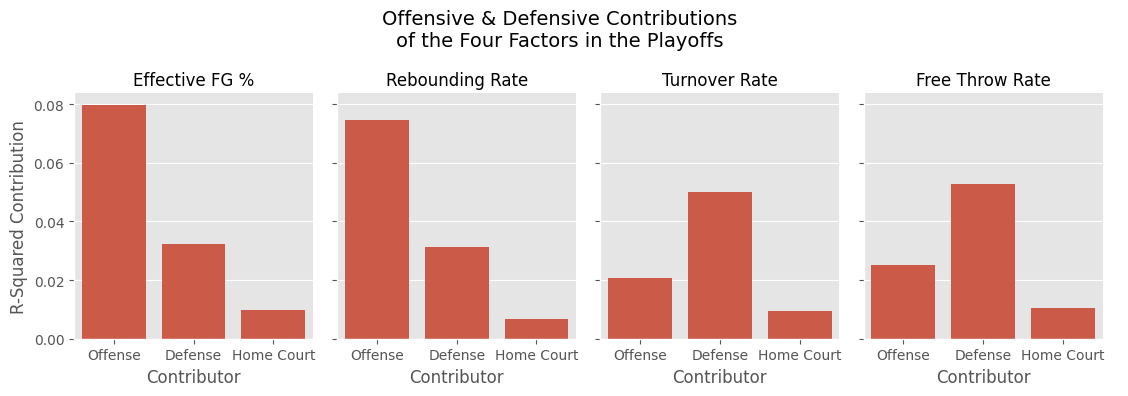

In [88]:
ax = sns.catplot(
    data=shap_values, x="Contributor", y="shapley_values", col="Stat",
    kind="bar", height=4, aspect=.7,
)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=0)
ax.set_axis_labels(x_var=None, y_var="R-Squared Contribution")
ax.fig.subplots_adjust(top=0.77)
ax.fig.suptitle('Offensive & Defensive Contributions\nof the Four Factors in the Playoffs', fontsize=14);

In [103]:
cmap = sns.color_palette("flare", as_cmap=True)

duckdb.sql("""SELECT Stat
    ,SUM(CASE WHEN Contributor = 'Offense' THEN shapley_values END) Offense
    ,SUM(CASE WHEN Contributor = 'Defense' THEN shapley_values END) Defense
    ,SUM(CASE WHEN Contributor = 'Home Court' THEN shapley_values END) "Home Court"
    ,SUM(shapley_values) AS "Total R-Squared"
FROM shap_values
GROUP BY Stat
ORDER BY "Total R-Squared" DESC""").df().style.hide().format({'Offense': '{:.3f}',
                'Defense': '{:.3f}',
                'Home Court': '{:.3f}',
                'Total R-Squared': '{:.3f}'}).background_gradient(subset=['Total R-Squared'],
                                   cmap=cmap,
                                   vmin=.05)

Stat,Offense,Defense,Home Court,Total R-Squared
Effective FG %,0.080,0.032,0.010,0.122
Rebounding Rate,0.074,0.031,0.007,0.112
Free Throw Rate,0.025,0.053,0.010,0.088
Turnover Rate,0.021,0.050,0.009,0.080


Using Shapley decomposition, we see that although we tend to place a higher importance on defence in the playoffs, it's really more of a mixed bag. For shooting and rebounding, the offense is a more important predictor of playoff performance than defense, while the opposite is true for turnovers and free throw rate. 

Most of this is consistent with the results that we got from measuring the stability of these metrics. The one surprise is that turnovers seem to depend on the defense more than the offense. Based on their stability, we might have expected those contributions to be about the same.

We can also look at the total R-Squared to see which metrics are overall the most predictable based on regular season stats. These results are also pretty consistent with what we saw when we measured stability.

### Additional Thoughts

* When we measure stability by separating the seasons into halves, some of correlations were very close, and it's not clear whether or not a difference of .03 means anything or not. We could account for that by using bootstrapping to take uncertainty into account. If a bootrap yields confidence intervals that overlap significantly, that would tell us that there may not be a significant difference in stability between two metrics.

* Here, we only predicted performance on the team level. That wouldn't take into account in-season injuried or transactions. Some have used an RAPM style approach to measure individual players' impact on the four factors. That approach could potentially give us more accurate out of sample predictions.